In [5]:
import json
import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 120)

# Paths
path_list = Path("steam-app-list.jsonl")
path_raw = Path("steam-raw-app-data.jsonl")

def read_jsonl(path: Path):
    # Try pandas first
    try:
        return pd.read_json(path, lines=True)
    except ValueError:
        # fallback to manual line-by-line
        rows = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                rows.append(json.loads(line))
        return pd.DataFrame(rows)

# Load files
df_list = read_jsonl(path_list)
df_raw = read_jsonl(path_raw)

# Normalize likely id columns
def normalize_id_cols(df):
    for col in ["appid", "app_id", "id", "steam_appid"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")
    return df

df_list = normalize_id_cols(df_list)
df_raw = normalize_id_cols(df_raw)

# Heuristically choose a join key
join_cols_list = [c for c in df_list.columns if c in ["appid", "app_id", "id", "steam_appid"]]
join_cols_raw  = [c for c in df_raw.columns if c in ["appid", "app_id", "id", "steam_appid"]]

join_col = None
for c in ["steam_appid", "appid", "app_id", "id"]:
    if c in join_cols_list and c in join_cols_raw:
        join_col = c
        break

# Quick previews (limited rows for display)
preview_list = df_list.head(20).copy()
preview_raw  = df_raw.head(20).copy()

# Build a combined frame
if join_col is not None:
    df = df_list.merge(df_raw, on=join_col, how="outer", suffixes=("_list", "_raw"))
else:
    # If no common join key, just keep them separate with row numbers
    df_list["_row"] = np.arange(len(df_list))
    df_raw["_row"]  = np.arange(len(df_raw))
    df = pd.merge(df_list, df_raw, on="_row", how="outer", suffixes=("_list", "_raw"))

# Identify potential useful columns by fuzzy matching
cols = df.columns.str.lower()

def find_cols(patterns):
    found = []
    for p in patterns:
        found.extend([c for c in df.columns if re.search(p, c, flags=re.I)])
    # keep unique preserving order
    seen = set()
    uniq = []
    for c in found:
        if c not in seen:
            uniq.append(c)
            seen.add(c)
    return uniq

genre_cols   = find_cols([r"\bgenre", r"\btags?", r"\bcategory"])
price_cols   = find_cols([r"\bprice", r"\binitialprice", r"\brelease.*price"])
review_cols  = find_cols([r"review", r"positive", r"negative", r"rating"])
date_cols    = find_cols([r"release.*date", r"\bdate\b", r"\byear\b"])
owner_cols   = find_cols([r"\bowners?\b", r"\bsales?\b", r"\bunits?\b", r"\bplayers?\b", r"\bconcurrent\b"])
name_cols    = find_cols([r"\bname\b", r"\btitle\b"])

schema_summary = {
    "rows_total": len(df),
    "join_key_used": join_col,
    "genre_cols": genre_cols[:8],
    "price_cols": price_cols[:8],
    "review_cols": review_cols[:8],
    "date_cols": date_cols[:8],
    "owner_cols": owner_cols[:8],
    "name_cols": name_cols[:8],
}

# Helper: parse owners range like "200,000 .. 500,000" into midpoint integer
def parse_owners(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        return val
    s = str(val)
    # Try to capture two numbers
    m = re.findall(r"[\d,]+", s)
    if not m:
        return np.nan
    nums = [int(x.replace(",", "")) for x in m]
    if len(nums) == 1:
        return nums[0]
    return int(np.mean(nums))

# Try to form candidate feature/target columns
# Choose first matching columns where possible
def first_or_none(lst):
    return lst[0] if lst else None

col_name   = first_or_none(name_cols)
col_genre  = first_or_none([c for c in genre_cols if df[c].notna().any()])
col_price  = first_or_none([c for c in price_cols if df[c].notna().any()])
col_rel    = first_or_none([c for c in date_cols if df[c].notna().any()])
col_owners = first_or_none([c for c in owner_cols if df[c].notna().any()])

# Derive features
work = pd.DataFrame(index=df.index)

if join_col:
    work["app_id"] = df[join_col]
if col_name:
    work["name"] = df[col_name]
if col_genre:
    # genres might be list, dict, or comma-separated string
    def primary_genre(x):
        if isinstance(x, list):
            return x[0] if x else np.nan
        if isinstance(x, dict):
            # pick the first key or 'description' if present
            if "description" in x:
                return x["description"]
            return next(iter(x.values())) if x else np.nan
        if isinstance(x, str):
            # split on comma/semicolon
            parts = re.split(r"[;,/|]", x)
            return parts[0].strip() if parts else x.strip()
        return np.nan
    work["primary_genre"] = df[col_genre].apply(primary_genre)

if col_price:
    # many Steam prices are in cents; normalize to USD
    price_series = pd.to_numeric(df[col_price], errors="coerce")
    # heuristic: if median > 200, it's probably cents
    if np.nanmedian(price_series) and np.nanmedian(price_series) > 200:
        price_series = price_series / 100.0
    work["price_usd"] = price_series

# Build a review ratio if possible
pos_col = first_or_none([c for c in review_cols if re.search("positive", c, flags=re.I)])
neg_col = first_or_none([c for c in review_cols if re.search("negative", c, flags=re.I)])
ratio = None
if pos_col and neg_col:
    pos = pd.to_numeric(df[pos_col], errors="coerce")
    neg = pd.to_numeric(df[neg_col], errors="coerce")
    total = pos + neg
    ratio = np.where(total > 0, pos / total, np.nan)
    work["review_pos_ratio"] = ratio

# Release year
if col_rel:
    rel = pd.to_datetime(df[col_rel], errors="coerce")
    work["release_year"] = rel.dt.year

# Target: owners/sales midpoint
if col_owners:
    owners_mid = df[col_owners].apply(parse_owners)
    work["owners_midpoint"] = pd.to_numeric(owners_mid, errors="coerce")
    # Target in thousands (to stabilize scale)
    work["owners_k"] = work["owners_midpoint"] / 1000.0

# Drop rows with no target
if "owners_k" in work.columns:
    tidy = work.dropna(subset=["owners_k"]).copy()
else:
    tidy = work.copy()

# Basic cleaning
# Keep only reasonable prices and years
if "price_usd" in tidy.columns:
    tidy.loc[(tidy["price_usd"] < 0) | (tidy["price_usd"] > 200), "price_usd"] = np.nan

if "release_year" in tidy.columns:
    tidy.loc[(tidy["release_year"] < 2000) | (tidy["release_year"] > 2026), "release_year"] = np.nan

# Show previews for user
# Print first 20 rows for each preview DataFrame, if defined
def print_head(df, name, n=20):
    try:
        import pandas as pd
        if isinstance(df, pd.DataFrame):
            print(f"\n=== {name} (first {n} rows) ===")
            print(df.head(n).to_string(index=False))
        else:
            # Try to coerce to DataFrame; else just print first 20 items
            try:
                df2 = pd.DataFrame(df)
                print(f"\n=== {name} (first {n} rows, coerced) ===")
                print(df2.head(n).to_string(index=False))
            except Exception:
                print(f"\n=== {name} (first {n} items) ===")
                try:
                    for i, x in enumerate(list(df)[:n]):
                        print(i, x)
                except Exception:
                    print(df)
    except Exception as e:
        print(f"[Error printing {name}: {e}]")

try:
    print_head(preview_list, "steam-app-list", 20)
except NameError:
    print("preview_list not defined.")

try:
    print_head(preview_raw, "steam-raw-app-data", 20)
except NameError:
    print("preview_raw not defined.")

try:
    print_head(work, "Schema-driven feature draft", 20)
except NameError:
    print("work not defined.")

# Quick summary (printed)
def safe_len(x):
    try:
        return int(len(x))
    except Exception:
        return None

summary = {
    "rows_after_join": safe_len(df) if 'df' in globals() else None,
    "rows_with_target": safe_len(tidy) if 'tidy' in globals() else None,
    "candidate_name_col": globals().get("col_name"),
    "candidate_genre_col": globals().get("col_genre"),
    "candidate_price_col": globals().get("col_price"),
    "candidate_release_col": globals().get("col_rel"),
    "candidate_owners_col": globals().get("col_owners"),
}

print("\n=== Quick summary ===")
for k, v in summary.items():
    print(f"{k}: {v}")



=== steam-app-list (first 20 rows) ===
 appid                                          name
     5                              Dedicated Server
     7                                  Steam Client
     8                                        winui2
    10                                Counter-Strike
    20                         Team Fortress Classic
    30                                 Day of Defeat
    40                            Deathmatch Classic
    50                     Half-Life: Opposing Force
    60                                      Ricochet
    70                                     Half-Life
    80                Counter-Strike: Condition Zero
    90                    Half-Life Dedicated Server
    92                               Codename Gordon
   100 Counter-Strike: Condition Zero Deleted Scenes
   130                         Half-Life: Blue Shift
   150                Counter-Strike Steamworks Beta
   205                       Source Dedicated Server
   210

/tmp/ipykernel_167/2718437266.py:155: RuntimeWarning: All-NaN slice encountered
  if np.nanmedian(price_series) and np.nanmedian(price_series) > 200:


In [7]:
import re
import numpy as np
import pandas as pd

# --- helpers to normalize Steam fields ---

def parse_price_overview(po):
    """
    Steam price_overview is usually a dict with:
      {'currency': 'USD', 'initial': 999, 'final': 499, 'discount_percent': 50, ...}
    Values are in minor units (e.g., cents). Returns price in major units (e.g., USD).
    """
    if isinstance(po, dict):
        # Prefer 'final' if present, else 'initial'
        cents = po.get('final', po.get('initial', None))
        if isinstance(cents, (int, float)):
            return cents / 100.0
        # Sometimes only formatted is present
        for key in ('final_formatted', 'initial_formatted'):
            s = po.get(key)
            if isinstance(s, str):
                # Handle "Free", "$9.99", "9,99€", etc.
                if s.strip().lower().startswith("free"):
                    return 0.0
                # Keep digits and . , then normalize comma decimals
                t = re.sub(r"[^\d,\.]", "", s)
                # If both comma and dot appear, assume dot is decimal; otherwise swap comma->dot
                if "," in t and "." not in t:
                    t = t.replace(",", ".")
                try:
                    return float(t)
                except Exception:
                    return np.nan
        return np.nan
    elif isinstance(po, (int, float)):
        # Assume cents
        return po / 100.0
    elif isinstance(po, str):
        s = po.strip().lower()
        if s.startswith("free"):
            return 0.0
        t = re.sub(r"[^\d,\.]", "", po)
        if "," in t and "." not in t:
            t = t.replace(",", ".")
        try:
            return float(t)
        except Exception:
            return np.nan
    return np.nan

def parse_release_date(rd):
    """
    Steam 'release_date' is often a dict: {'coming_soon': False, 'date': 'Jan 1, 2023'}.
    Returns pandas.Timestamp or NaT.
    """
    if isinstance(rd, dict):
        rd = rd.get('date')
    return pd.to_datetime(rd, errors='coerce')

def parse_owners_range(s):
    """
    SteamSpy owners often come like '20,000 .. 50,000'. Returns midpoint as int.
    """
    if isinstance(s, str):
        nums = re.findall(r"[\d,]+", s)
        if len(nums) >= 2:
            lo = int(nums[0].replace(",", ""))
            hi = int(nums[1].replace(",", ""))
            return (lo + hi) // 2
        elif len(nums) == 1:
            return int(nums[0].replace(",", ""))
    return np.nan

# --- build clean columns on your working DataFrame (adjust df/work as needed) ---

# If your working table is `df`, use that; else if `work` is the draft table, use `work`.
_base = df if 'df' in globals() else (work if 'work' in globals() else None)
if _base is None:
    print("No working DataFrame found (expected 'df' or 'work').")
else:
    # Create normalized columns
    if 'price_overview' in _base.columns:
        _base['price_clean'] = _base['price_overview'].apply(parse_price_overview)
    else:
        _base['price_clean'] = np.nan

    if 'release_date' in _base.columns:
        _base['release_date_clean'] = _base['release_date'].apply(parse_release_date)
    else:
        _base['release_date_clean'] = pd.NaT

    # Owners: only if you have such a column; you said candidate_owners_col is None
    owners_col_guess = None  # put your column name here if/when you have it, e.g., 'owners'
    if owners_col_guess and owners_col_guess in _base.columns:
        _base['owners_mid'] = _base[owners_col_guess].apply(parse_owners_range)
    else:
        _base['owners_mid'] = np.nan

    # --- safe median check (prevents the All-NaN warning) ---
    price_series = pd.to_numeric(_base['price_clean'], errors='coerce')
    if price_series.notna().any():
        med = float(np.nanmedian(price_series))
        # Example heuristic you hinted at:
        if med > 200:  # likely cents vs dollars mix somewhere
            print(f"[note] median price {med} looks high; are these cents? If so divide by 100.")
    else:
        med = np.nan
        print("[note] No non-NaN prices; skipping median-based checks.")

    # --- print first 20 rows of the key columns ---
    cols_to_show = [c for c in ['name', 'price_overview', 'price_clean', 'release_date', 'release_date_clean', 'owners_mid'] if c in _base.columns]
    print("\n=== First 20 rows (cleaned price/release/owners) ===")
    print(_base[cols_to_show].head(20).to_string(index=False))



=== First 20 rows (cleaned price/release/owners) ===
                                                                                                               price_overview  price_clean                                   release_date release_date_clean  owners_mid
{'currency': 'USD', 'initial': 999, 'final': 999, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '$9.99'}         9.99  {'coming_soon': False, 'date': 'Nov 1, 2000'}         2000-11-01         NaN
{'currency': 'USD', 'initial': 499, 'final': 499, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '$4.99'}         4.99  {'coming_soon': False, 'date': 'Apr 1, 1999'}         1999-04-01         NaN
{'currency': 'USD', 'initial': 499, 'final': 499, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '$4.99'}         4.99  {'coming_soon': False, 'date': 'May 1, 2003'}         2003-05-01         NaN
{'currency': 'USD', 'initial': 499, 'final': 499, 'discount_percent': 0, 'init

In [9]:
# Fix extractors to operate on individual cells instead of whole rows

def extract_price_usd_cell(val):
    if isinstance(val, dict):
        cents = val.get("final", val.get("initial", np.nan))
        try:
            cents = float(cents)
        except Exception:
            cents = np.nan
        return cents / 100.0 if pd.notna(cents) else np.nan
    return np.nan

def extract_release_year_cell(val):
    if isinstance(val, dict):
        d = val.get("date")
        dt = pd.to_datetime(d, errors="coerce")
        if pd.notna(dt):
            return int(dt.year)
    return np.nan

def extract_reviews_total_cell(val):
    if isinstance(val, dict):
        return pd.to_numeric(val.get("total"), errors="coerce")
    return np.nan

def extract_primary_genre_cell(val):
    if isinstance(val, list) and len(val) > 0:
        first = val[0]
        if isinstance(first, dict):
            return first.get("description") or first.get("name")
        return str(first)
    if isinstance(val, dict):
        return val.get("description") or val.get("name")
    if isinstance(val, str):
        parts = re.split(r"[;,/|]", val)
        return parts[0].strip() if parts else val.strip()
    return np.nan

ex2 = pd.DataFrame({
    "appid": df.get("appid"),
    "name": df.get("name_raw", df.get("name_list", df.get("name"))),
    "primary_genre": df.get("genres").apply(extract_primary_genre_cell) if "genres" in df.columns else np.nan,
    "price_usd": df.get("price_overview").apply(extract_price_usd_cell) if "price_overview" in df.columns else np.nan,
    "release_year": df.get("release_date").apply(extract_release_year_cell) if "release_date" in df.columns else np.nan,
    "reviews_total": df.get("recommendations").apply(extract_reviews_total_cell) if "recommendations" in df.columns else np.nan,
})

# Now filter
ex2_clean = ex2.dropna(subset=["reviews_total", "primary_genre", "price_usd", "release_year"])
len(ex2), ex2_clean.shape, ex2_clean.head(10).to_dict(orient="records")



(273670,
 (1222, 6),
 [{'appid': 5,
   'name': 'Counter-Strike',
   'primary_genre': 'Action',
   'price_usd': 9.99,
   'release_year': 2000.0,
   'reviews_total': 162764.0},
  {'appid': 7,
   'name': 'Team Fortress Classic',
   'primary_genre': 'Action',
   'price_usd': 4.99,
   'release_year': 1999.0,
   'reviews_total': 6686.0},
  {'appid': 8,
   'name': 'Day of Defeat',
   'primary_genre': 'Action',
   'price_usd': 4.99,
   'release_year': 2003.0,
   'reviews_total': 4327.0},
  {'appid': 10,
   'name': 'Deathmatch Classic',
   'primary_genre': 'Action',
   'price_usd': 4.99,
   'release_year': 2001.0,
   'reviews_total': 2349.0},
  {'appid': 20,
   'name': 'Half-Life: Opposing Force',
   'primary_genre': 'Action',
   'price_usd': 4.99,
   'release_year': 1999.0,
   'reviews_total': 23049.0},
  {'appid': 30,
   'name': 'Ricochet',
   'primary_genre': 'Action',
   'price_usd': 4.99,
   'release_year': 2000.0,
   'reviews_total': 4393.0},
  {'appid': 40,
   'name': 'Half-Life',
   'pr

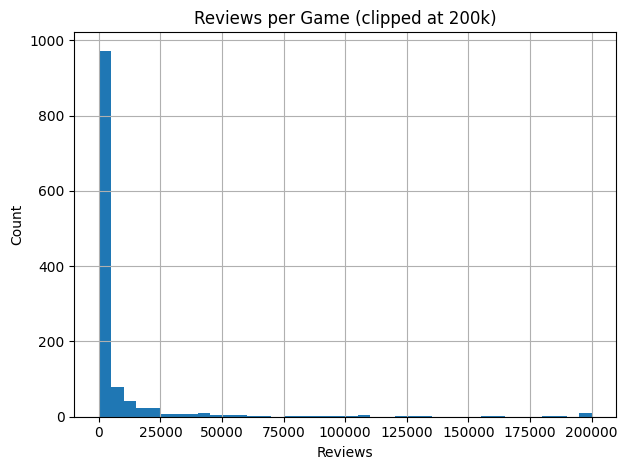

In [11]:
# Train a simple baseline model to predict log(reviews_total)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

tidy = ex2_clean.copy()
tidy["log_reviews"] = np.log1p(tidy["reviews_total"])

X = tidy[["primary_genre", "price_usd", "release_year"]]
y = tidy["log_reviews"]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["primary_genre"]),
    ("num", "passthrough", ["price_usd", "release_year"]),
])

model = Pipeline([("prep", preprocess), ("linreg", LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae_reviews = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))

# Plot histogram of reviews (clipped to 200k) for intuition
plt.figure()
tidy["reviews_total"].clip(upper=200000).hist(bins=40)
plt.title("Reviews per Game (clipped at 200k)")
plt.xlabel("Reviews")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Export modeling dataset
out_path = "steam_tidy_for_modeling.csv"
tidy.to_csv(out_path, index=False)

# Show some genre stats
genre_stats = tidy.groupby("primary_genre")["reviews_total"].median().sort_values(ascending=False).head(15).reset_index()
